In [1]:
import sys
assert sys.version_info >= (3, 5)

import sklearn
assert sklearn.__version__ >= "0.20"

import numpy as np
import os

np.random.seed(42)

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [2]:
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

In [3]:
logit_clf = LogisticRegression()
rand_forest_clf = RandomForestClassifier()
svm_clf = SVC()

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=10000, noise=0.4)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

"hard" voting

In [5]:
voting_clf = VotingClassifier(
    estimators=[
        ('lr', logit_clf),
        ('rf', rand_forest_clf),
        ('svc', svm_clf),
    ],
    voting='hard'
)
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression()),
                             ('rf', RandomForestClassifier()), ('svc', SVC())])

In [6]:
from sklearn.metrics import accuracy_score
for classifier in (logit_clf, rand_forest_clf, svm_clf, voting_clf):
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    print(classifier.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.8415
RandomForestClassifier 0.853
SVC 0.874
VotingClassifier 0.8685


"soft" voting

In [7]:
logit_clf = LogisticRegression(solver="lbfgs")
rand_forest_clf = RandomForestClassifier(n_estimators=100)
svm_clf = SVC(gamma="scale", probability=True)

voting_clf = VotingClassifier(
    estimators=[
        ('lr', logit_clf),
        ('rf', rand_forest_clf),
        ('svc', svm_clf)
    ],
    voting='soft')
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression()),
                             ('rf', RandomForestClassifier()),
                             ('svc', SVC(probability=True))],
                 voting='soft')

In [8]:
from sklearn.metrics import accuracy_score
for classifier in (logit_clf, rand_forest_clf, svm_clf, voting_clf):
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    print(classifier.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.8415
RandomForestClassifier 0.853
SVC 0.874
VotingClassifier 0.8725


"Bagging" - bootstrap aggregating - sampling with replacement

"Pasting" - sampling without replacement

In [9]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bagging_clf = BaggingClassifier(
    estimator=DecisionTreeClassifier(),
    n_estimators=500,
    max_samples=100,
    bootstrap=True,
    n_jobs=-1  # using all CPU cores
)
bagging_clf.fit(X_train, y_train)
y_pred = bagging_clf.predict(X_test)

In [10]:
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)
y_pred_tree = tree_clf.predict(X_test)
print(accuracy_score(y_test, y_pred_tree))

0.8145


In [11]:
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.45, -1, 1.5], alpha=0.2, contour=True):
    x1s = np.linspace(axes[0], axes[1], 200)
    x2s = np.linspace(axes[2], axes[3], 200)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.9, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

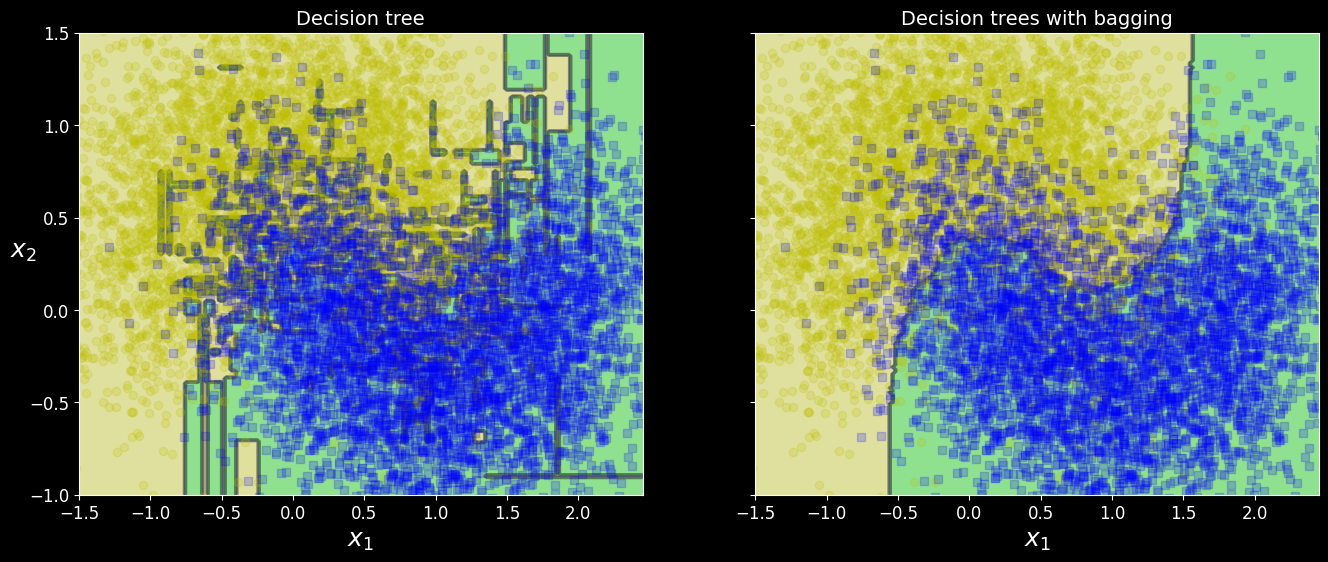

In [12]:
fix, axes = plt.subplots(ncols=2, figsize=(16,6), sharey=True)
plt.sca(axes[0])
plot_decision_boundary(tree_clf, X, y)
plt.title("Decision tree", fontsize=14)
plt.sca(axes[1])
plot_decision_boundary(bagging_clf, X, y)
plt.title("Decision trees with bagging", fontsize=14)
plt.ylabel("")
plt.show()

"OOB" - out-of-bag instances - means what would be the accuracy score on the testing data (approximate)

In [13]:
bagging_clf = BaggingClassifier(
    DecisionTreeClassifier(),
    n_estimators=500,
    bootstrap=True,
    n_jobs=-1,
    oob_score=True,
)

bagging_clf.fit(X_train, y_train)
bagging_clf.oob_score_

0.8355

In [14]:
y_pred = bagging_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.8495

In [15]:
bagging_clf.oob_decision_function_

array([[0.87373737, 0.12626263],
       [1.        , 0.        ],
       [0.28877005, 0.71122995],
       ...,
       [0.        , 1.        ],
       [0.        , 1.        ],
       [0.68556701, 0.31443299]])

In [16]:
from sklearn.ensemble import RandomForestClassifier

rand_forest_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1)
rand_forest_clf.fit(X_train, y_train)

y_pred_rf = rand_forest_clf.predict(X_test)

In [17]:
accuracy_score(y_test, y_pred_rf)

0.871

In [18]:
from sklearn.ensemble import ExtraTreesClassifier

extra_clf = ExtraTreesClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1)
extra_clf.fit(X_train, y_train)

y_pred_extra = extra_clf.predict(X_test)

In [19]:
accuracy_score(y_test, y_pred_extra)

0.866

In [20]:
from sklearn.ensemble import AdaBoostClassifier

adaboost_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1),  # decision stump
    n_estimators=200,
    algorithm="SAMME.R",
    learning_rate=0.5,
)
adaboost_clf.fit(X_train, y_train)

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.5, n_estimators=200)

In [21]:
accuracy_score(y_test, adaboost_clf.predict(X_test))

0.861

MNIST data

In [22]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1)

/Users/Bartek/Desktop/Bartek/Programowanie/Portfolio/venv/lib/python3.11/site-packages/sklearn/datasets/_openml.py:1022: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [23]:
mnist.target = mnist.target.astype(np.uint8)

Checking features importances

In [24]:
rnd_clf = RandomForestClassifier(n_estimators=100)
rnd_clf.fit(mnist["data"], mnist["target"])

RandomForestClassifier()

[Text(1, 0.0, 'Least important'),
 Text(1, 0.011063390397620481, 'Most important')]

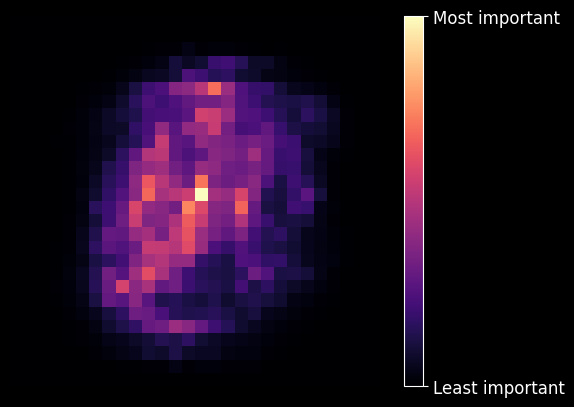

In [25]:
image = rnd_clf.feature_importances_.reshape(28, 28)
plt.imshow(image, cmap = mpl.cm.magma, interpolation="nearest")
plt.axis("off")
cbar = plt.colorbar(ticks=[rnd_clf.feature_importances_.min(), rnd_clf.feature_importances_.max()])
cbar.ax.set_yticklabels(['Least important', 'Most important'])

In [26]:
X_train_val, X_test, y_train_val, y_test = train_test_split(mnist.data, mnist.target, test_size=10000)  # first split into training and test sets
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=10000)  # then split into training and validation sets

In [27]:
# trainig some classifiers
from sklearn.neural_network import MLPClassifier
from sklearn.svm import LinearSVC

rand_forest_clf = RandomForestClassifier(n_estimators=100)
extra_trees_clf = ExtraTreesClassifier(n_estimators=100)
linear_svm_clf = LinearSVC()
mlp_clf = MLPClassifier()

In [28]:
estimators = [rand_forest_clf, extra_trees_clf, svm_clf, mlp_clf]
for estimator in estimators:
    print("Model: ", estimator)
    estimator.fit(X_train, y_train)

Model:  RandomForestClassifier()
Model:  ExtraTreesClassifier()
Model:  SVC(probability=True)
Model:  MLPClassifier()


In [29]:
[estimator.score(X_val, y_val) for estimator in estimators]

[0.9682, 0.9701, 0.9788, 0.9689]

In [33]:
voting_clf = VotingClassifier(
    [
        ('rand_forest_clf', rand_forest_clf),
        ('extra_trees_clf', extra_trees_clf),
        ('linear_svm_clf', linear_svm_clf),
        ('mlp_clf', mlp_clf)
    ],
    voting='hard'
)
voting_clf.fit(X_train, y_train)

/Users/Bartek/Desktop/Bartek/Programowanie/Portfolio/venv/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/Bartek/Desktop/Bartek/Programowanie/Portfolio/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


VotingClassifier(estimators=[('rand_forest_clf', RandomForestClassifier()),
                             ('extra_trees_clf', ExtraTreesClassifier()),
                             ('linear_svm_clf', LinearSVC()),
                             ('mlp_clf', MLPClassifier())])

In [34]:
voting_clf.score(X_val, y_val)

0.9696